# Analyse correlations and select features
We want to get an overview about the covariates to make and check assumptions about the SCHUFA-based data generating process. Then we want to select the most fitting transformations of the features.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
data_path = "/media/veracrypt1/SPON_dataset_tables/"
plot_path = "plots/"

In [3]:
table2 = pd.read_csv(data_path + "datasets_v2/20190703_analysis_dataset_versandbank_final_cleaned.csv", sep=";")

In [4]:
def prepare_type(df_data):
    # Nominal features
    df_data["sex"] = df_data["sex"].astype("category")
    df_data["familyStatus"] = df_data["familyStatus"].astype("category")
    df_data["employment"] = df_data["employment"].astype("category")
    df_data["housing"] = df_data["housing"].astype("category")
    df_data["east_west"] = df_data["east_west"].astype("category")

    # Ordinal features
    cat_ordtype = pd.api.types.CategoricalDtype(categories=[500, 1000, 2000, 3000, 4000, 5000], ordered=True)

    df_data["monthlyIncome"] = df_data["monthlyIncome"].astype(cat_ordtype)
    df_data["activeLoanAmount"] = df_data["activeLoanAmount"].astype(cat_ordtype)
    df_data["paidOffLoanAmount"] = df_data["paidOffLoanAmount"].astype(cat_ordtype)
    
    return df_data

In [6]:
table2 = prepare_type(table2)

In [7]:
# As an example we use versandhandel V1
domain = "Versandhandel"
version = 1

df_data = table2[(table2["domain"]==domain) & (table2["version"]==version)]

## Feature selection - LASSO Regression

In [8]:
df_data.columns

Index(['id', 'date', 'table', 'customer', 'feature', 'domain', 'version',
       'score', 'value', 'level', 'meaning', 'stoerung', 'kredit_jahr',
       'kredit_nutzung', 'kredit_historie', 'allgemein', 'anschrift',
       'all_columns_text', 'activeLoanAmount', 'admonition', 'cashing',
       'employment', 'executionProceedings', 'familyStatus', 'housing',
       'insolvencyProceedings', 'mailOrder', 'migrationBackground',
       'monthlyIncome', 'numberOfActiveLoans', 'numberOfChildren',
       'numberOfCreditCards', 'numberOfGiroAccounts',
       'numberOfMobileContracts', 'numberOfPaidOffLoans', 'paidOffLoanAmount',
       'plz', 'relocation', 'schufaDate', 'sex', 'yearOfBirth', 'foreigner',
       'basisscore', 'plz_one', 'east_west', 'age', 'age_class', 'age_gen',
       'request', 'banking_connection', 'business_relation', 'conditions',
       'credit_card', 'giro', 'global_credit', 'identity', 'secured_loan',
       'solvency', 'telecom', 'unsecured_loan', 'Banken_req',
       

In [11]:
df_data.iloc[:, -26:].columns

Index(['request', 'banking_connection', 'business_relation', 'conditions',
       'credit_card', 'giro', 'global_credit', 'identity', 'secured_loan',
       'solvency', 'telecom', 'unsecured_loan', 'Banken_req',
       'Freiberufler_req', 'Genossenschaftsbanken_req', 'Handel_req',
       'Hypothekengeschäft_req', 'Kleingewerbetreibende_req', 'Sparkassen_req',
       'Sparkassen/Genossenschaftsbanken_req',
       'Telekommunikationsunternehmen_req', 'Versandhandel_req', 'credit_days',
       'credit_card_days', 'giro_days', 'finance_year'],
      dtype='object')

In [12]:
df_data.iloc[:, -26:] = df_data.iloc[:, -26:].fillna(0)

/home/phil/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [27]:
def get_feature_lists(domain):
    # Separate Columns into data types as well as predictors and target

    nominal = ["sex", "east_west", "mailOrder"]
    nom_idx = len(nominal)

    metric = ['monthlyIncome', 'age', 'relocation', # questionnaire data
              'request', 'banking_connection', 'business_relation', 'conditions',
              'credit_card', 'giro', 'global_credit', 'identity', 'secured_loan',
              'solvency', 'telecom', 'unsecured_loan', # feature counts
              domain+'_req', 'finance_year', # request/time counts
              'credit_days', 'credit_card_days', 'giro_days'] # time-based

    target = ["score"]



    # Separate Columns into counts (discrete with zero-inflation) and non-counts

    counts = ['relocation', 
              'request', 'banking_connection', 'business_relation', 'conditions',
              'credit_card', 'giro', 'global_credit', 'identity', 'secured_loan',
              'solvency', 'telecom', 'unsecured_loan',
              domain+'_req', 'finance_year']

    non_counts = ["female", "east", "mailOrder",
                  'monthlyIncome', 'age', 
                  'credit_days', 'credit_card_days', 'giro_days']
    
    return nominal, nom_idx, metric, target, counts, non_counts

In [186]:
df_data.iloc[:, -26:] = df_data.iloc[:, -26:].fillna(0)

nominal, nom_idx, metric, target, counts, non_counts = get_feature_lists(domain)
relevant_feats = target + nominal + metric

Xy = df_data[relevant_feats]
print(Xy.shape)
Xy = Xy.dropna()
print(Xy.shape)

(1615, 24)
(1255, 24)


In [187]:
metric.remove("monthlyIncome")
nominal += ["monthlyIncome"]
metric, nominal

(['age',
  'relocation',
  'request',
  'banking_connection',
  'business_relation',
  'conditions',
  'credit_card',
  'giro',
  'global_credit',
  'identity',
  'secured_loan',
  'solvency',
  'telecom',
  'unsecured_loan',
  'Versandhandel_req',
  'finance_year',
  'credit_days',
  'credit_card_days',
  'giro_days'],
 ['sex', 'east_west', 'mailOrder', 'monthlyIncome'])

In [188]:
df_metric = Xy[metric] # [:, (nom_idx+1):]
df_nominal = Xy[nominal] # [:, 1:(nom_idx+1)]
y = Xy[target] # [:, 0]

In [189]:
# Code nominal feature
df_female = pd.get_dummies(df_nominal.sex.astype("category"))["female"].reset_index(drop=True).to_frame()
df_east = pd.get_dummies(df_nominal.east_west.astype("category"))["east"].reset_index(drop=True).to_frame()
df_mail = df_nominal.mailOrder.astype(int).reset_index(drop=True).to_frame()
df_monthlyIncome = df_nominal.monthlyIncome.reset_index(drop=True).cat.codes.to_frame()
df_monthlyIncome.columns = ["monthlyIncome"]

df_nominal = pd.concat([df_female, df_east, df_mail, df_monthlyIncome], axis=1)

In [190]:
# Expand metric features
poly_2 = df_metric.apply(lambda x: x**2)
poly_2.columns = poly_2.columns + "_**2"

poly_3 = df_metric.apply(lambda x: x**3)
poly_3.columns = poly_3.columns + "_**3"

log_2 = df_metric.apply(lambda x: np.log(x+1))
log_2.columns = log_2.columns + "_log2"

In [191]:
# Compute interaction terms

interactions = pd.DataFrame(index = df_metric.index)

for idx, feat in enumerate(df_metric.columns):
    for interact in df_metric.columns[idx+1:]:
        interactions[feat+"*"+interact] = df_metric[feat]*df_metric[interact]

In [192]:
# append features
#metric_Xy = pd.concat([y, metric, poly_2], axis=1)

metric_Xy = pd.concat([y, df_metric, poly_2, poly_3, log_2, interactions], axis=1)
metric_Xy_nointeract = pd.concat([y, df_metric, poly_2, poly_3, log_2], axis=1)
metric_Xy_onlyinteract = pd.concat([y, df_metric, interactions], axis=1)

metric_Xy.columns

Index(['score', 'age', 'relocation', 'request', 'banking_connection',
       'business_relation', 'conditions', 'credit_card', 'giro',
       'global_credit',
       ...
       'Versandhandel_req*finance_year', 'Versandhandel_req*credit_days',
       'Versandhandel_req*credit_card_days', 'Versandhandel_req*giro_days',
       'finance_year*credit_days', 'finance_year*credit_card_days',
       'finance_year*giro_days', 'credit_days*credit_card_days',
       'credit_days*giro_days', 'credit_card_days*giro_days'],
      dtype='object', length=248)

In [193]:
# scale metric features
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

metric_Xy_scaled = pd.DataFrame(scaler.fit_transform(metric_Xy), columns=metric_Xy.columns)

metric_Xy_nointeract_scaled = pd.DataFrame(scaler.fit_transform(metric_Xy_nointeract), columns=metric_Xy_nointeract.columns)

metric_Xy_onlyinteract_scaled = pd.DataFrame(scaler.fit_transform(metric_Xy_onlyinteract), columns=metric_Xy_onlyinteract.columns)

In [194]:
# concatenate all features and separate y
y_scaled = metric_Xy_scaled["score"]
X_scaled = pd.concat([df_nominal, metric_Xy_scaled.iloc[:,1:]], axis=1)

y_scaled_nointeract = metric_Xy_nointeract_scaled["score"]
X_scaled_nointeract = pd.concat([df_nominal, metric_Xy_nointeract_scaled.iloc[:,1:]], axis=1)

y_scaled_onlyinteract = metric_Xy_onlyinteract_scaled["score"]
X_scaled_onlyinteract = pd.concat([df_nominal, metric_Xy_onlyinteract_scaled.iloc[:,1:]], axis=1)

In [195]:
X_scaled.head(5)

,female,east,mailOrder,monthlyIncome,age,relocation,request,banking_connection,business_relation,conditions,...,Versandhandel_req*finance_year,Versandhandel_req*credit_days,Versandhandel_req*credit_card_days,Versandhandel_req*giro_days,finance_year*credit_days,finance_year*credit_card_days,finance_year*giro_days,credit_days*credit_card_days,credit_days*giro_days,credit_card_days*giro_days
0,0,0,0,5,1.271940,-1.173579,0.091137,-0.240485,-0.242289,-0.255848,...,-0.165536,-0.130945,-0.179498,-0.233176,-0.241682,-0.305036,-0.360148,-0.296498,-0.330628,-0.613157
1,0,0,1,2,1.465971,-0.570203,-0.599268,3.440105,-0.242289,-0.255848,...,-0.165536,-0.130945,-0.179498,-0.233176,-0.241682,-0.305036,-0.360148,-0.296498,-0.330628,-0.613157
2,0,0,1,3,-0.571345,0.033174,0.551407,-0.240485,-0.242289,1.534610,...,-0.165536,-0.130945,-0.179498,-0.233176,-0.241682,-0.115318,4.222819,-0.296498,-0.330628,-0.546080
3,0,0,1,3,-0.765375,0.033174,4.693837,-0.240485,-0.242289,-0.255848,...,-0.165536,-0.130945,-0.179498,-0.233176,-0.241682,-0.305036,-0.360148,-0.296498,-0.330628,-0.613157
4,0,0,1,3,-0.474330,0.636550,-0.599268,-0.240485,-0.242289,-0.255848,...,-0.165536,-0.130945,-0.179498,-0.233176,-0.241682,-0.305036,-0.360148,-0.296498,-0.330628,-0.533154


### Apply LASSO regression for comparison

In [196]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.linear_model import Lasso
from sklearn.linear_model import ARDRegression

In [205]:
# Base-Model: Linear Regression
reg = LinearRegression().fit(X_scaled, y_scaled)
cv_res = cross_validate(reg, X_scaled, y_scaled, cv=4)
print(np.mean(cv_res["train_score"]))
print(np.mean(cv_res["test_score"]))

0.6641679403717173
-2.918622480563186e+18


In [222]:
# get best model-parameter for every dataset and estimate coefficients 
from sklearn.linear_model import LassoCV
import warnings
warnings.filterwarnings("ignore")

lreg = LassoCV(cv=4, max_iter=5000, random_state=9001, n_jobs=6)
lreg.fit(X_scaled, y_scaled)
print(lreg.score(X_scaled, y_scaled), "Alpha:", lreg.alpha_)

0.5911426648521534 Alpha: 0.011356996574383093


In [223]:
lreg.mse_path_[lreg.alphas_==lreg.alpha_].sum()/4

0.4517220229138838

In [224]:
lreg.coef_.reshape(-1,1).shape, X_scaled.columns.shape

((251, 1), (251,))

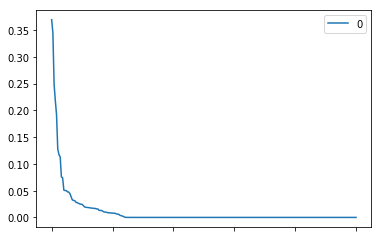

In [225]:
coefs = pd.DataFrame(lreg.coef_.reshape(-1,1).T, columns=X_scaled.columns).T
abs(coefs).sort_values(0, ascending=False).plot()

In [226]:
abs(coefs[abs(coefs)[0]>.05]).sort_values(0, ascending=False)

,0
age_log2,0.369418
solvency_log2,0.344579
credit_card_days_log2,0.248665
female,0.218293
finance_year_log2,0.191674
relocation_**2,0.127810
Versandhandel_req_log2,0.117238
credit_card_days,0.113125
credit_card_days_**3,0.075614
relocation*giro_days,0.074122


### Use Initialization techniques to select features for each domain and version

In [49]:
quest_feat = ["sex", "score", "age", "relocation"] # east_west, monthlyIncome

# We also dont need the features that have been aggregated:
# business_credit_card, business_giro, global_credit, line_of_credit, giro, credit_card
schufa_feat = ['request', 'address_update', 'banking_connection',
               'business_relation', 'conditions', 'identity',
               'lease_purchase', 'mail_order', 'permanent_account', 
               'rent_request', 'secured_loan', 'solvency', 'telecom', 'unsecured_loan', 'giro_aggr',
               'credit_card_aggr', 'credit_aggr', 'Versandhandel_req', 'credit_days',
               'credit_card_days', 'giro_days']

In [308]:
for domain in ["Versandhandel", "Banken"]:
    for version in [1, 2 ,3]:
        
        print(domain, version)
        
        df_data = table2[(table2["domain"]==domain) & (table2["version"]==version)]

        
        df_data.iloc[:, -26:] = df_data.iloc[:, -26:].fillna(0)

        nominal, nom_idx, metric, target, counts, non_counts = get_feature_lists(domain)
        relevant_feats = target + nominal + metric

        Xy = df_data[relevant_feats]
        print(Xy.shape)
        Xy = Xy.dropna()
        print(Xy.shape)

        metric.remove("monthlyIncome")
        nominal += ["monthlyIncome"]
        metric, nominal

        df_metric = Xy[metric] # [:, (nom_idx+1):]
        df_nominal = Xy[nominal] # [:, 1:(nom_idx+1)]
        y = Xy[target] # [:, 0]

        if version != 1:
            y = y.apply(lambda x: 1000-np.log(10000-x)*100)

        ############

        # Code nominal feature
        df_female = pd.get_dummies(df_nominal.sex.astype("category"))["female"].reset_index(drop=True).to_frame()
        df_east = pd.get_dummies(df_nominal.east_west.astype("category"))["east"].reset_index(drop=True).to_frame()
        df_mail = df_nominal.mailOrder.astype(int).reset_index(drop=True).to_frame()
        df_monthlyIncome = df_nominal.monthlyIncome.reset_index(drop=True).cat.codes.to_frame()
        df_monthlyIncome.columns = ["monthlyIncome"]

        df_nominal = pd.concat([df_female, df_east, df_mail, df_monthlyIncome], axis=1)

        # Expand metric features
        poly_2 = df_metric.apply(lambda x: x**2)
        poly_2.columns = poly_2.columns + "_**2"

        poly_3 = df_metric.apply(lambda x: x**3)
        poly_3.columns = poly_3.columns + "_**3"

        log_2 = df_metric.apply(lambda x: np.log(x+1))
        log_2.columns = log_2.columns + "_log2"

        # Compute interaction terms

        interactions = pd.DataFrame(index = df_metric.index)

        for idx, feat in enumerate(df_metric.columns):
            for interact in df_metric.columns[idx+1:]:
                interactions[feat+"*"+interact] = df_metric[feat]*df_metric[interact]

        ####################################

        # append features
        #metric_Xy = pd.concat([y, metric, poly_2], axis=1)

        metric_Xy = pd.concat([y, df_metric, poly_2, poly_3, log_2, interactions], axis=1)
        metric_Xy_nointeract = pd.concat([y, df_metric, poly_2, poly_3, log_2], axis=1)
        metric_Xy_onlyinteract = pd.concat([y, df_metric, interactions], axis=1)

        metric_Xy.columns

        # scale metric features
        from sklearn.preprocessing import StandardScaler

        scaler = StandardScaler()

        metric_Xy_scaled = pd.DataFrame(scaler.fit_transform(metric_Xy_nointeract), 
                                        columns=metric_Xy_nointeract.columns)

        ####################################

        # concatenate all features and separate y
        y_scaled = metric_Xy_scaled["score"]
        X_scaled = pd.concat([df_nominal, metric_Xy_scaled.iloc[:,1:]], axis=1)


        ####################################

        # get best model-parameter for every dataset and estimate coefficients 

        print("Use LASSO")
        for idx, data in enumerate([(X_scaled, y_scaled)]):
            lasso = LassoCV(cv=4, max_iter=100000, random_state=42598)
            lasso.fit(data[0], data[1])
            print("R^2:", lasso.score(data[0], data[1]), "alpha:", lasso.alpha_)
            print("Avg. CV MSE:", lasso.mse_path_[lasso.alphas_==lasso.alpha_].sum()/4)

            lasso_coefs = pd.Series(lasso.coef_, index=data[0].columns)
            lasso_coefs.name = "weight"
            lasso_coefs.to_frame().to_csv("feature_selection/20190705_lasso_coefficients_%s_%d.csv"%(domain, version), sep=";")


Versandhandel 1
(1615, 24)
(1255, 24)
Use LASSO
R^2: 0.5755257125978417 alpha: 0.006060887488732292
Avg. CV MSE: 0.45071340880955557
Versandhandel 2
(1664, 24)
(1295, 24)
Use LASSO
R^2: 0.6451196216383179 alpha: 0.0008883203552217811
Avg. CV MSE: 0.39812267178538774
Versandhandel 3
(1671, 24)
(1302, 24)
Use LASSO
R^2: 0.6047661208730735 alpha: 0.0067879515375269045
Avg. CV MSE: 0.41993748446800183
Banken 1
(1633, 24)
(1272, 24)
Use LASSO
R^2: 0.6267109382712683 alpha: 0.000479496584581889
Avg. CV MSE: 0.4107620246495121
Banken 2
(1643, 24)
(1289, 24)
Use LASSO
R^2: 0.6642066938008886 alpha: 0.004089997812172781
Avg. CV MSE: 0.36603988703832624
Banken 3
(1577, 24)
(1221, 24)
Use LASSO
R^2: 0.6131520967266211 alpha: 0.005067138530365093
Avg. CV MSE: 0.41171595915139314


## Select feature transformation using cut off value

In [253]:
domain = "Versandhandel"
version = 1

coefs = pd.read_csv("feature_selection/20190704_lasso_coefficients_%s_%d.csv"%(domain, version), sep=";")
coefs = coefs.set_index(coefs.columns[0])

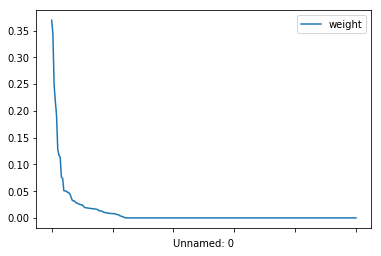

,weight
Unnamed: 0,
age_log2,0.369418
solvency_log2,0.344579
credit_card_days_log2,0.248665
female,0.218293
finance_year_log2,0.191674
relocation_**2,0.127810
Versandhandel_req_log2,0.117238
credit_card_days,0.113125
credit_card_days_**3,0.075614


In [255]:
abs(coefs).sort_values("weight", ascending=False).plot()
plt.show()
plt.close()
selection = abs(coefs[abs(coefs)["weight"]>.05]).sort_values("weight", ascending=False)
selection

In [252]:
pd.DataFrame(selection.index.tolist(), columns=["feature"]).to_csv("feature_selection/20190704_lasso_selection_%s_%d.csv"%(domain, version), sep=";", index=False)

In [256]:
domain = "Versandhandel"
version = 2

coefs = pd.read_csv("feature_selection/20190704_lasso_coefficients_%s_%d.csv"%(domain, version), sep=";")
coefs = coefs.set_index(coefs.columns[0])

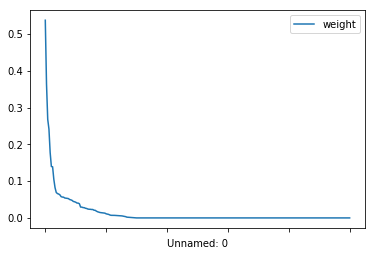

,weight
Unnamed: 0,
age_log2,0.537568
credit_card_days_log2,0.364102
solvency,0.268045
female,0.241611
age_**3,0.177623
age*giro,0.139739
request,0.139064
giro_days_log2,0.105073
secured_loan_log2,0.082369


In [259]:
abs(coefs).sort_values("weight", ascending=False).plot()
plt.show()
plt.close()
selection = abs(coefs[abs(coefs)["weight"]>.05]).sort_values("weight", ascending=False)
selection

In [260]:
pd.DataFrame(selection.index.tolist(), columns=["feature"]).to_csv("feature_selection/20190704_lasso_selection_%s_%d.csv"%(domain, version), sep=";", index=False)

In [261]:
domain = "Versandhandel"
version = 3

coefs = pd.read_csv("feature_selection/20190704_lasso_coefficients_%s_%d.csv"%(domain, version), sep=";")
coefs = coefs.set_index(coefs.columns[0])

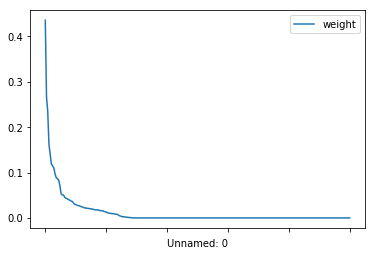

,weight
Unnamed: 0,
age_log2,0.435694
credit_card_days_log2,0.266513
solvency,0.235018
age*credit_card,0.162453
credit_card_days,0.141320
secured_loan_log2,0.118788
giro_days,0.114862
request,0.110368
relocation,0.097126


In [262]:
abs(coefs).sort_values("weight", ascending=False).plot()
plt.show()
plt.close()
selection = abs(coefs[abs(coefs)["weight"]>.05]).sort_values("weight", ascending=False)
selection

In [263]:
pd.DataFrame(selection.index.tolist(), columns=["feature"]).to_csv("feature_selection/20190704_lasso_selection_%s_%d.csv"%(domain, version), sep=";", index=False)

In [317]:
domain = "Banken"
version = 1

coefs = pd.read_csv("feature_selection/20190704_lasso_coefficients_%s_%d.csv"%(domain, version), sep=";")
coefs = coefs.set_index(coefs.columns[0])

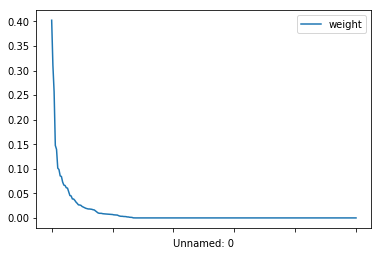

,weight
Unnamed: 0,
age_log2,0.402360
solvency_log2,0.311349
credit_card_days,0.256749
credit_card_days_log2,0.147609
request,0.139457
solvency,0.101377
age_**3,0.098422
credit_card_days_**3,0.085469
relocation_**2,0.084428


In [318]:
abs(coefs).sort_values("weight", ascending=False).plot()
plt.show()
plt.close()
selection = abs(coefs[abs(coefs)["weight"]>.04]).sort_values("weight", ascending=False)
selection

In [319]:
pd.DataFrame(selection.index.tolist(), columns=["feature"]).to_csv("feature_selection/20190704_lasso_selection_%s_%d.csv"%(domain, version), sep=";", index=False)

In [268]:
domain = "Banken"
version = 2

coefs = pd.read_csv("feature_selection/20190704_lasso_coefficients_%s_%d.csv"%(domain, version), sep=";")
coefs = coefs.set_index(coefs.columns[0])

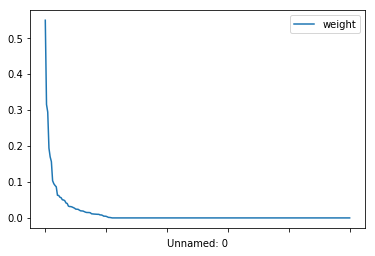

,weight
Unnamed: 0,
age_log2,0.549860
solvency,0.315618
credit_card_days_log2,0.294429
age*giro,0.194097
age_**3,0.169850
giro_days,0.156573
Banken_req,0.103601
request,0.095139
conditions_log2,0.090286


In [270]:
abs(coefs).sort_values("weight", ascending=False).plot()
plt.show()
plt.close()
selection = abs(coefs[abs(coefs)["weight"]>.04]).sort_values("weight", ascending=False)
selection

In [271]:
pd.DataFrame(selection.index.tolist(), columns=["feature"]).to_csv("feature_selection/20190704_lasso_selection_%s_%d.csv"%(domain, version), sep=";", index=False)

In [272]:
domain = "Banken"
version = 3

coefs = pd.read_csv("feature_selection/20190704_lasso_coefficients_%s_%d.csv"%(domain, version), sep=";")
coefs = coefs.set_index(coefs.columns[0])

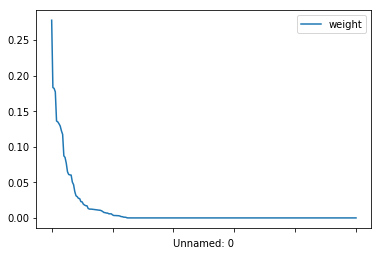

,weight
Unnamed: 0,
age_log2,0.277907
solvency,0.183298
solvency_log2,0.182087
finance_year_log2,0.177145
request,0.136221
giro_days,0.135083
secured_loan_log2,0.132430
credit_card_days_log2,0.129226
relocation_log2,0.122548


In [277]:
abs(coefs).sort_values("weight", ascending=False).plot()
plt.show()
plt.close()
selection = abs(coefs[abs(coefs)["weight"]>.03]).sort_values("weight", ascending=False)
selection

In [278]:
pd.DataFrame(selection.index.tolist(), columns=["feature"]).to_csv("feature_selection/20190704_lasso_selection_%s_%d.csv"%(domain, version), sep=";", index=False)

### Select most relevant feature transformation of each variable

In [320]:
for domain in ["Banken", "Versandhandel"]:
    for version in [1, 2, 3]:
        coefs = pd.read_csv("feature_selection/20190705_lasso_coefficients_%s_%d.csv"%(domain, version), sep=";")
        coefs = coefs.set_index(coefs.columns[0])

        rank = abs(coefs).sort_values("weight", ascending=False)

        # Get all used plain variables
        var_l = []
        for f in rank.index:
            f_split = f.rsplit('_', 1)
            if f_split[-1] in ["log2", "**2", "**3"]:
                var_l.append(f_split[0])
            else:
                var_l.append(f)

        # Get duplicate variables (multiple transformations)
        dupl_idx = pd.Series(var_l).duplicated(keep='first').values
        # Remove duplicate variables with less effect on response (score)
        best = rank[~dupl_idx]

        pd.Series(best.index).to_csv("feature_selection/20190705_lasso_selection_%s_%d.csv"%(domain, version), sep=";", index=False)